# Materials Project Element Distribution by Arity


In [ ]:
# dash needed for interactive plots
!pip install pymatviz dash

In [ ]:
import dash
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from dash.dependencies import Input, Output
from mp_api.client import MPRester

from pymatviz import count_elements, ptable_heatmap, ptable_heatmap_plotly
from pymatviz.enums import Key


__author__ = "Janosh Riebesell"
__date__ = "2022-07-21"


# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"

In [ ]:
print(", ".join(MPRester().materials.summary.available_fields))

builder_meta, nsites, elements, nelements, composition, composition_reduced, formula_pretty, formula_anonymous, chemsys, volume, density, density_atomic, symmetry, property_name, material_id, deprecated, deprecation_reasons, last_updated, origins, warnings, structure, task_ids, uncorrected_energy_per_atom, energy_per_atom, formation_energy_per_atom, energy_above_hull, is_stable, equilibrium_reaction_energy_per_atom, decomposes_to, xas, grain_boundaries, band_gap, cbm, vbm, efermi, is_gap_direct, is_metal, es_source_calc_id, bandstructure, dos, dos_energy_up, dos_energy_down, is_magnetic, ordering, total_magnetization, total_magnetization_normalized_vol, total_magnetization_normalized_formula_units, num_magnetic_sites, num_unique_magnetic_sites, types_of_magnetic_species, k_voigt, k_reuss, k_vrh, g_voigt, g_reuss, g_vrh, universal_anisotropy, homogeneous_poisson, e_total, e_ionic, e_electronic, n, e_ij_max, weighted_surface_energy_EV_PER_ANG2, weighted_surface_energy, weighted_work_func

In [ ]:
PMG_MAPI_KEY = "your Materials Project API key"

with MPRester(use_document_model=False) as mpr:
    mp_data = mpr.materials.summary.search(
        # num_elements=(None, 4),  # 4 or less elements
        fields=[Key.mat_id, Key.formula_pretty, "nelements"]
    )

Retrieving SummaryDoc documents:   0%|          | 0/153235 [00:00<?, ?it/s]

In [ ]:
df_mp = pd.DataFrame(map(dict, mp_data)).set_index("material_id")
df_mp.head()

In [ ]:
# uncomment line to cache large MP data
# %store df_mp

# uncomment line to load cached MP data from disk
%store -r df_mp

Stored 'df_mp' (DataFrame)


In [ ]:
elem_counts_by_arity = {
    label: count_elements(df_mp.query(f"nelements == {idx}")[Key.formula_pretty])
    for idx, label in enumerate(["unary", "binary", "ternary", "quaternary"], 1)
}

compound_counts_by_arity = {
    key: (df_mp.nelements == idx).sum()
    for idx, key in enumerate(elem_counts_by_arity, 1)
}

/Users/yang/developer/pymatviz/pymatviz/ptable/ptable_matplotlib.py:225: UserWarning:

Elements dropped due to close to zero value.

/Users/yang/developer/pymatviz/pymatviz/ptable/ptable_matplotlib.py:225: UserWarning:

Elements dropped due to close to zero value.

/Users/yang/developer/pymatviz/pymatviz/ptable/ptable_matplotlib.py:225: UserWarning:

Elements dropped due to close to zero value.

/Users/yang/developer/pymatviz/pymatviz/ptable/ptable_matplotlib.py:225: UserWarning:

Elements dropped due to close to zero value.



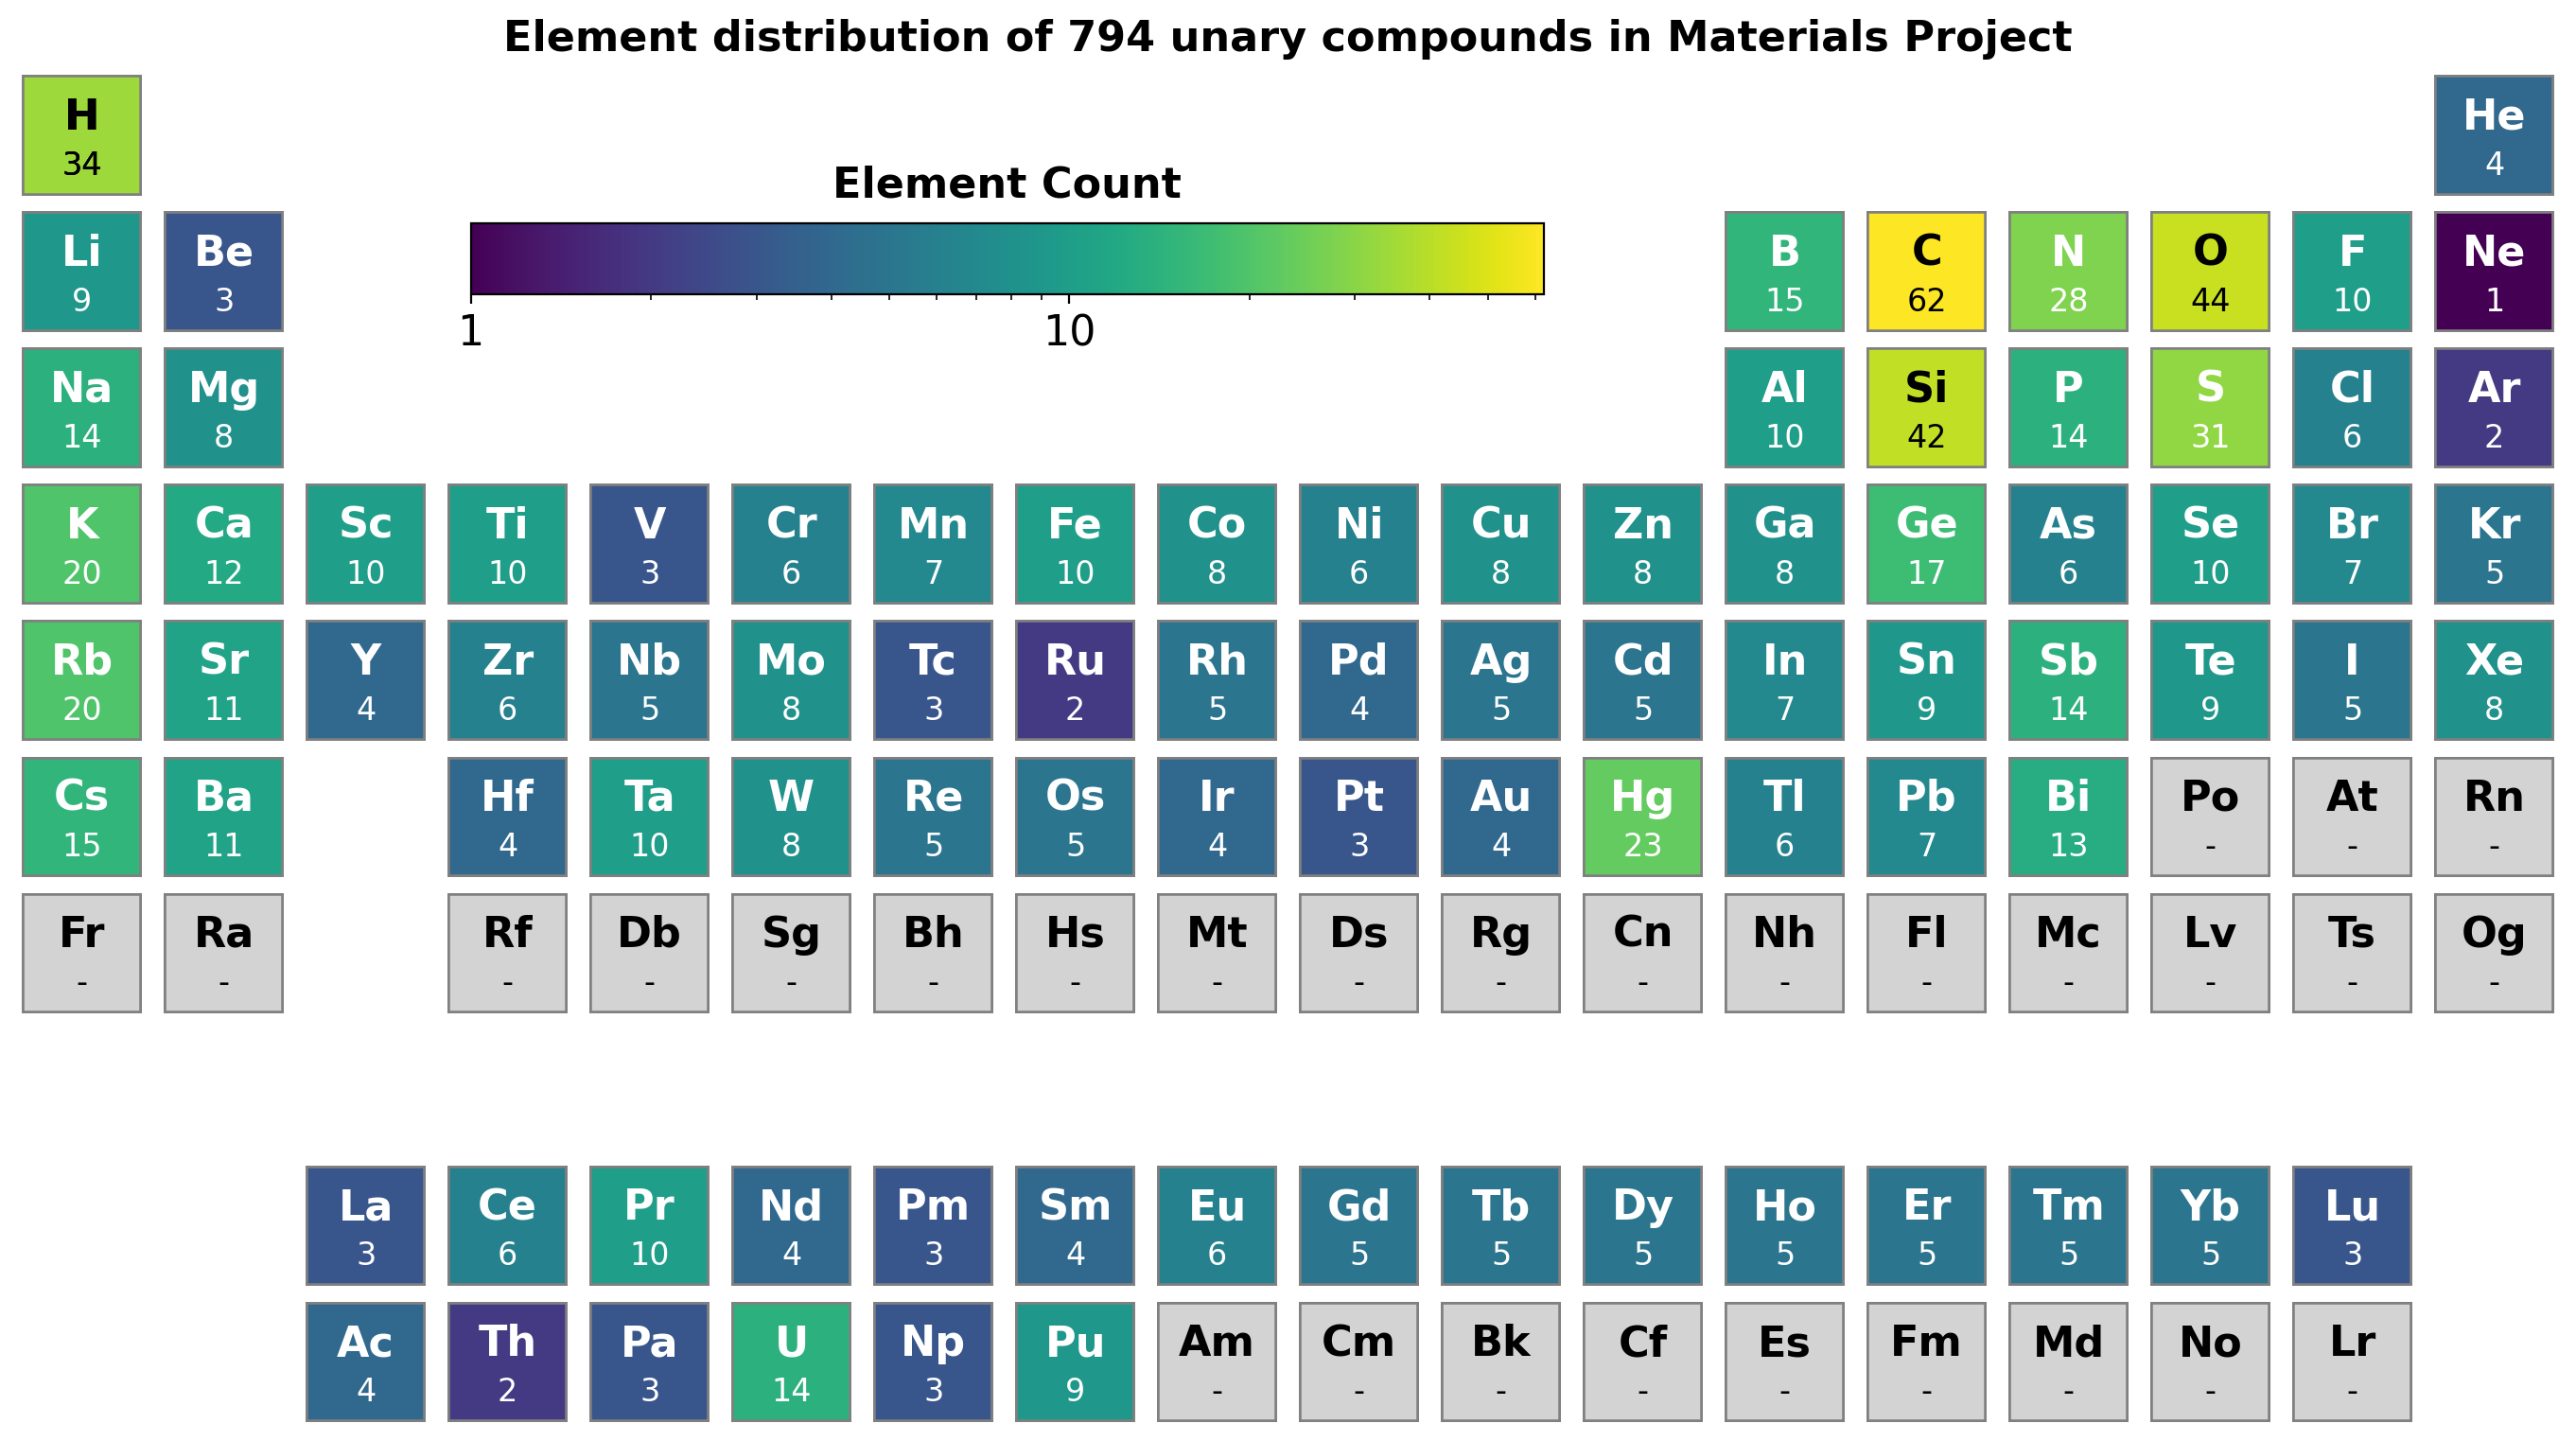

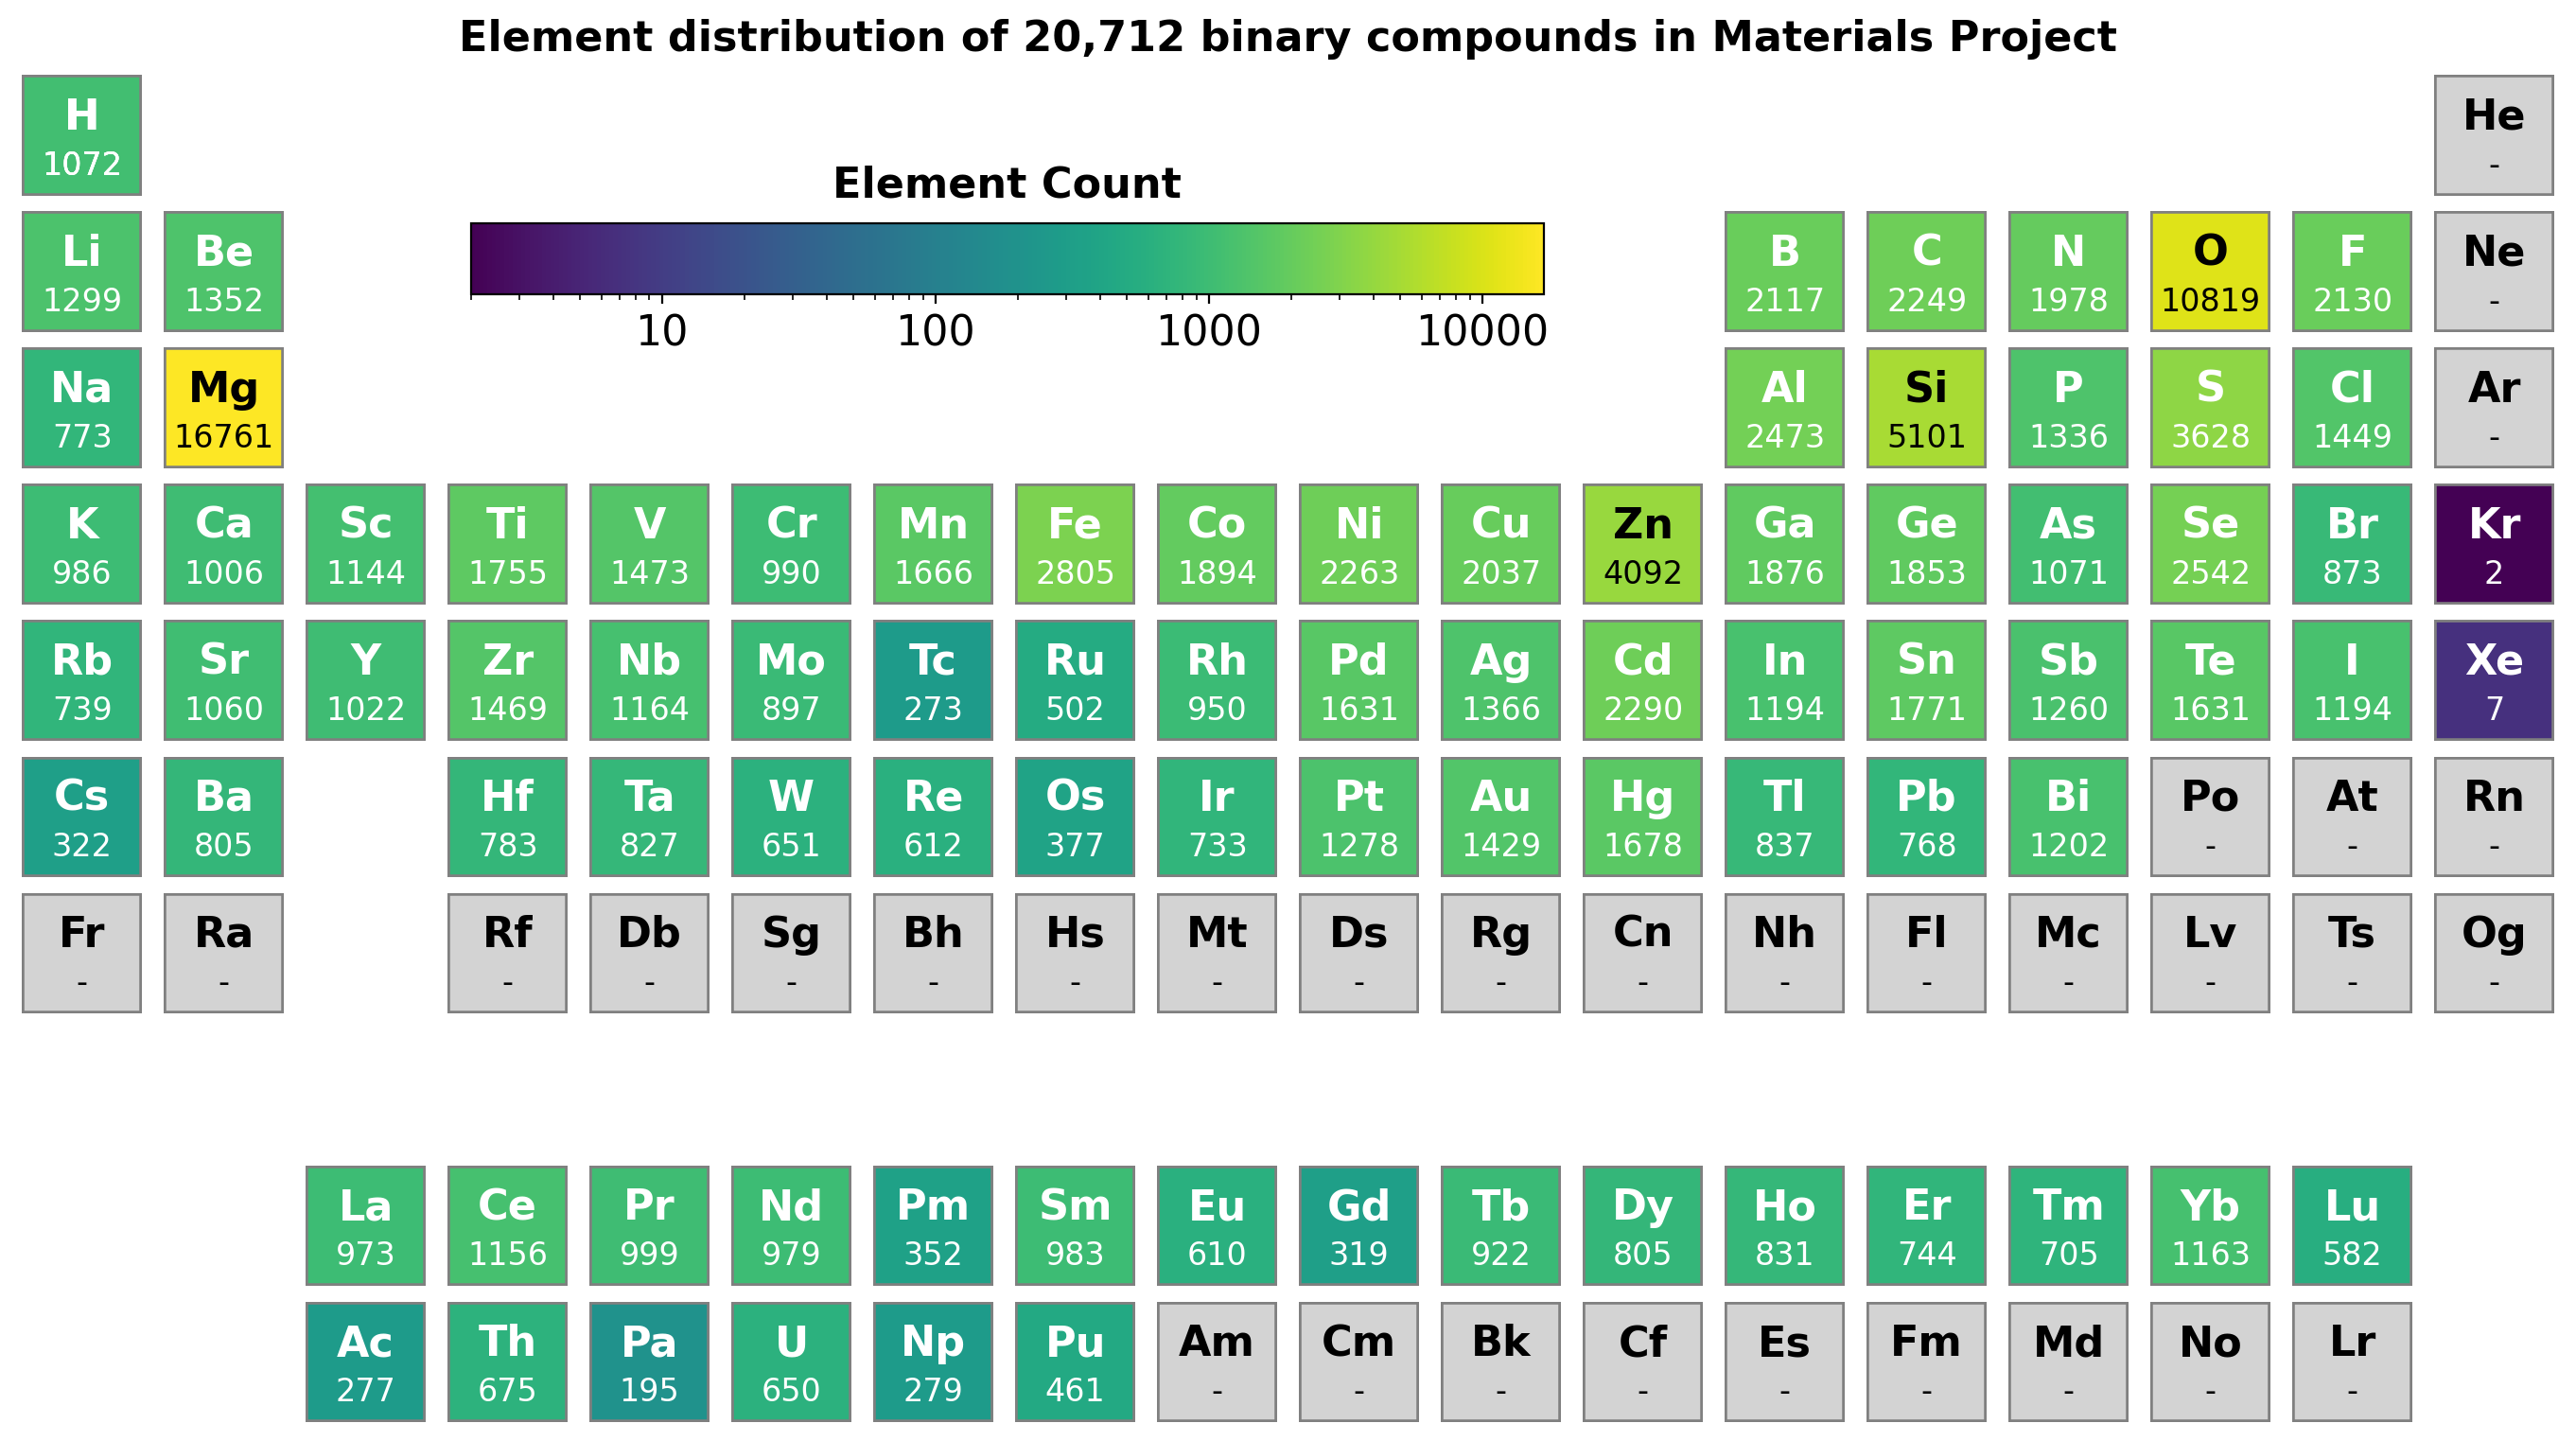

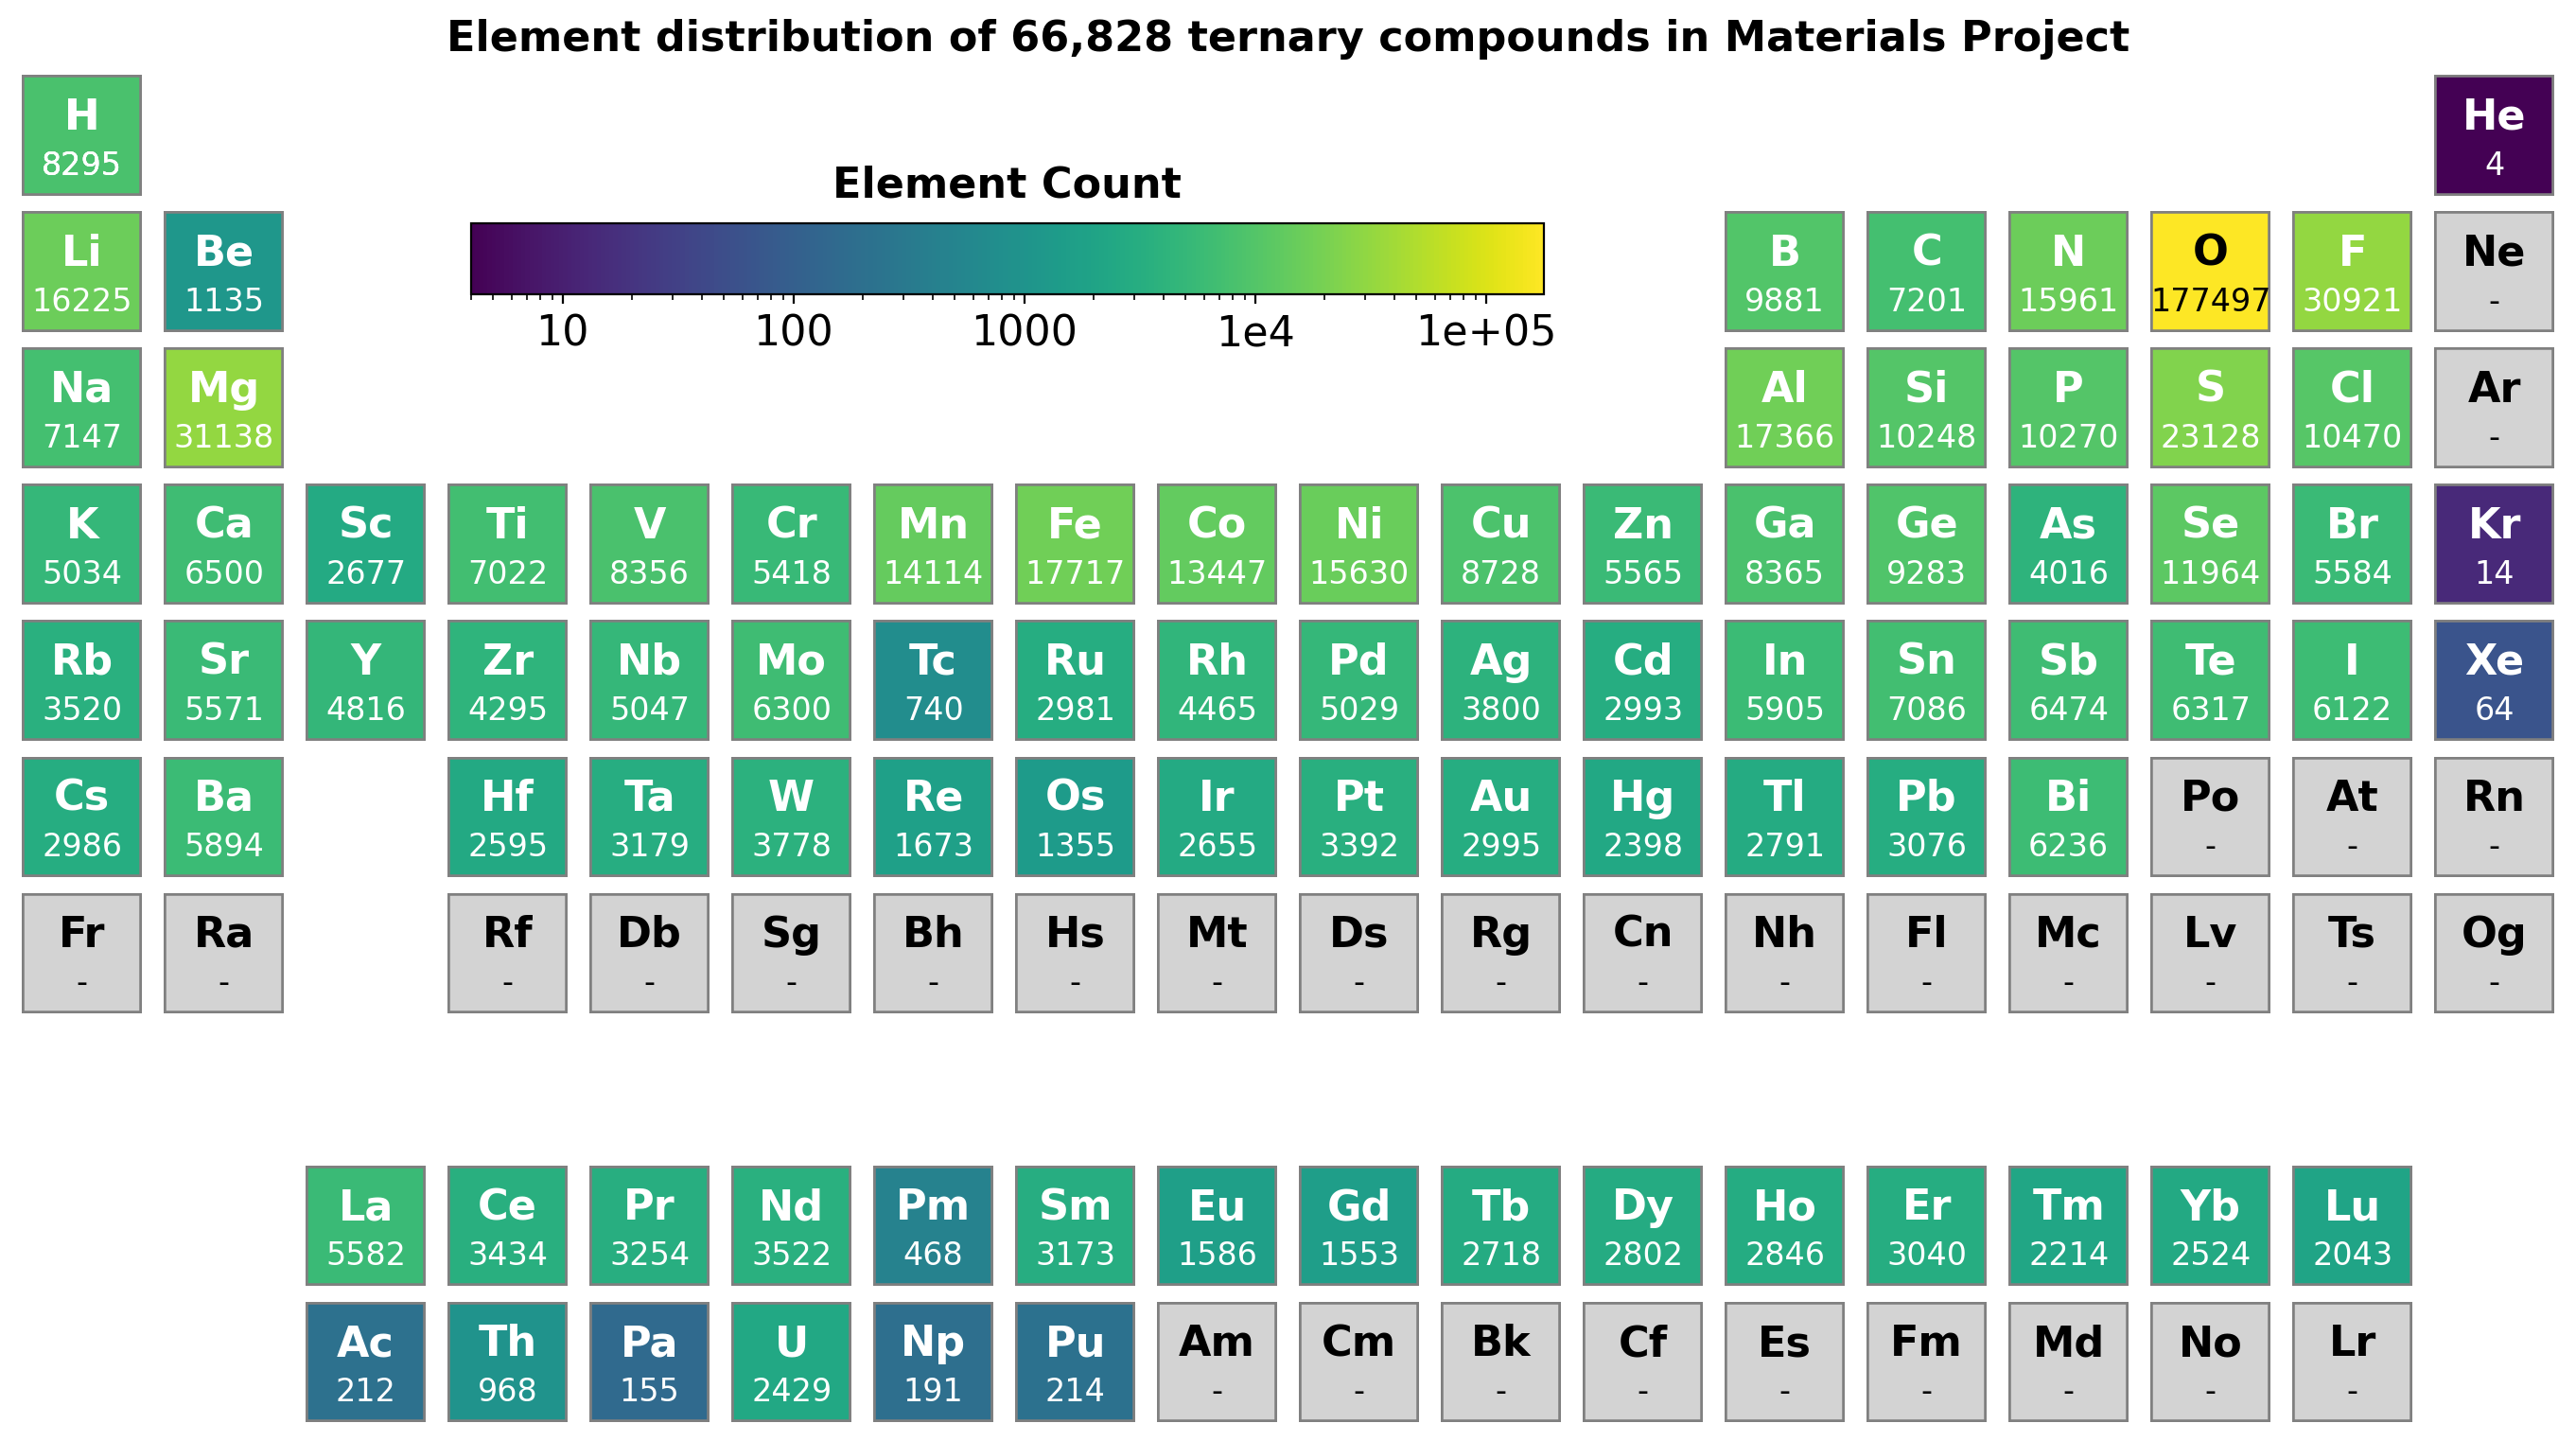

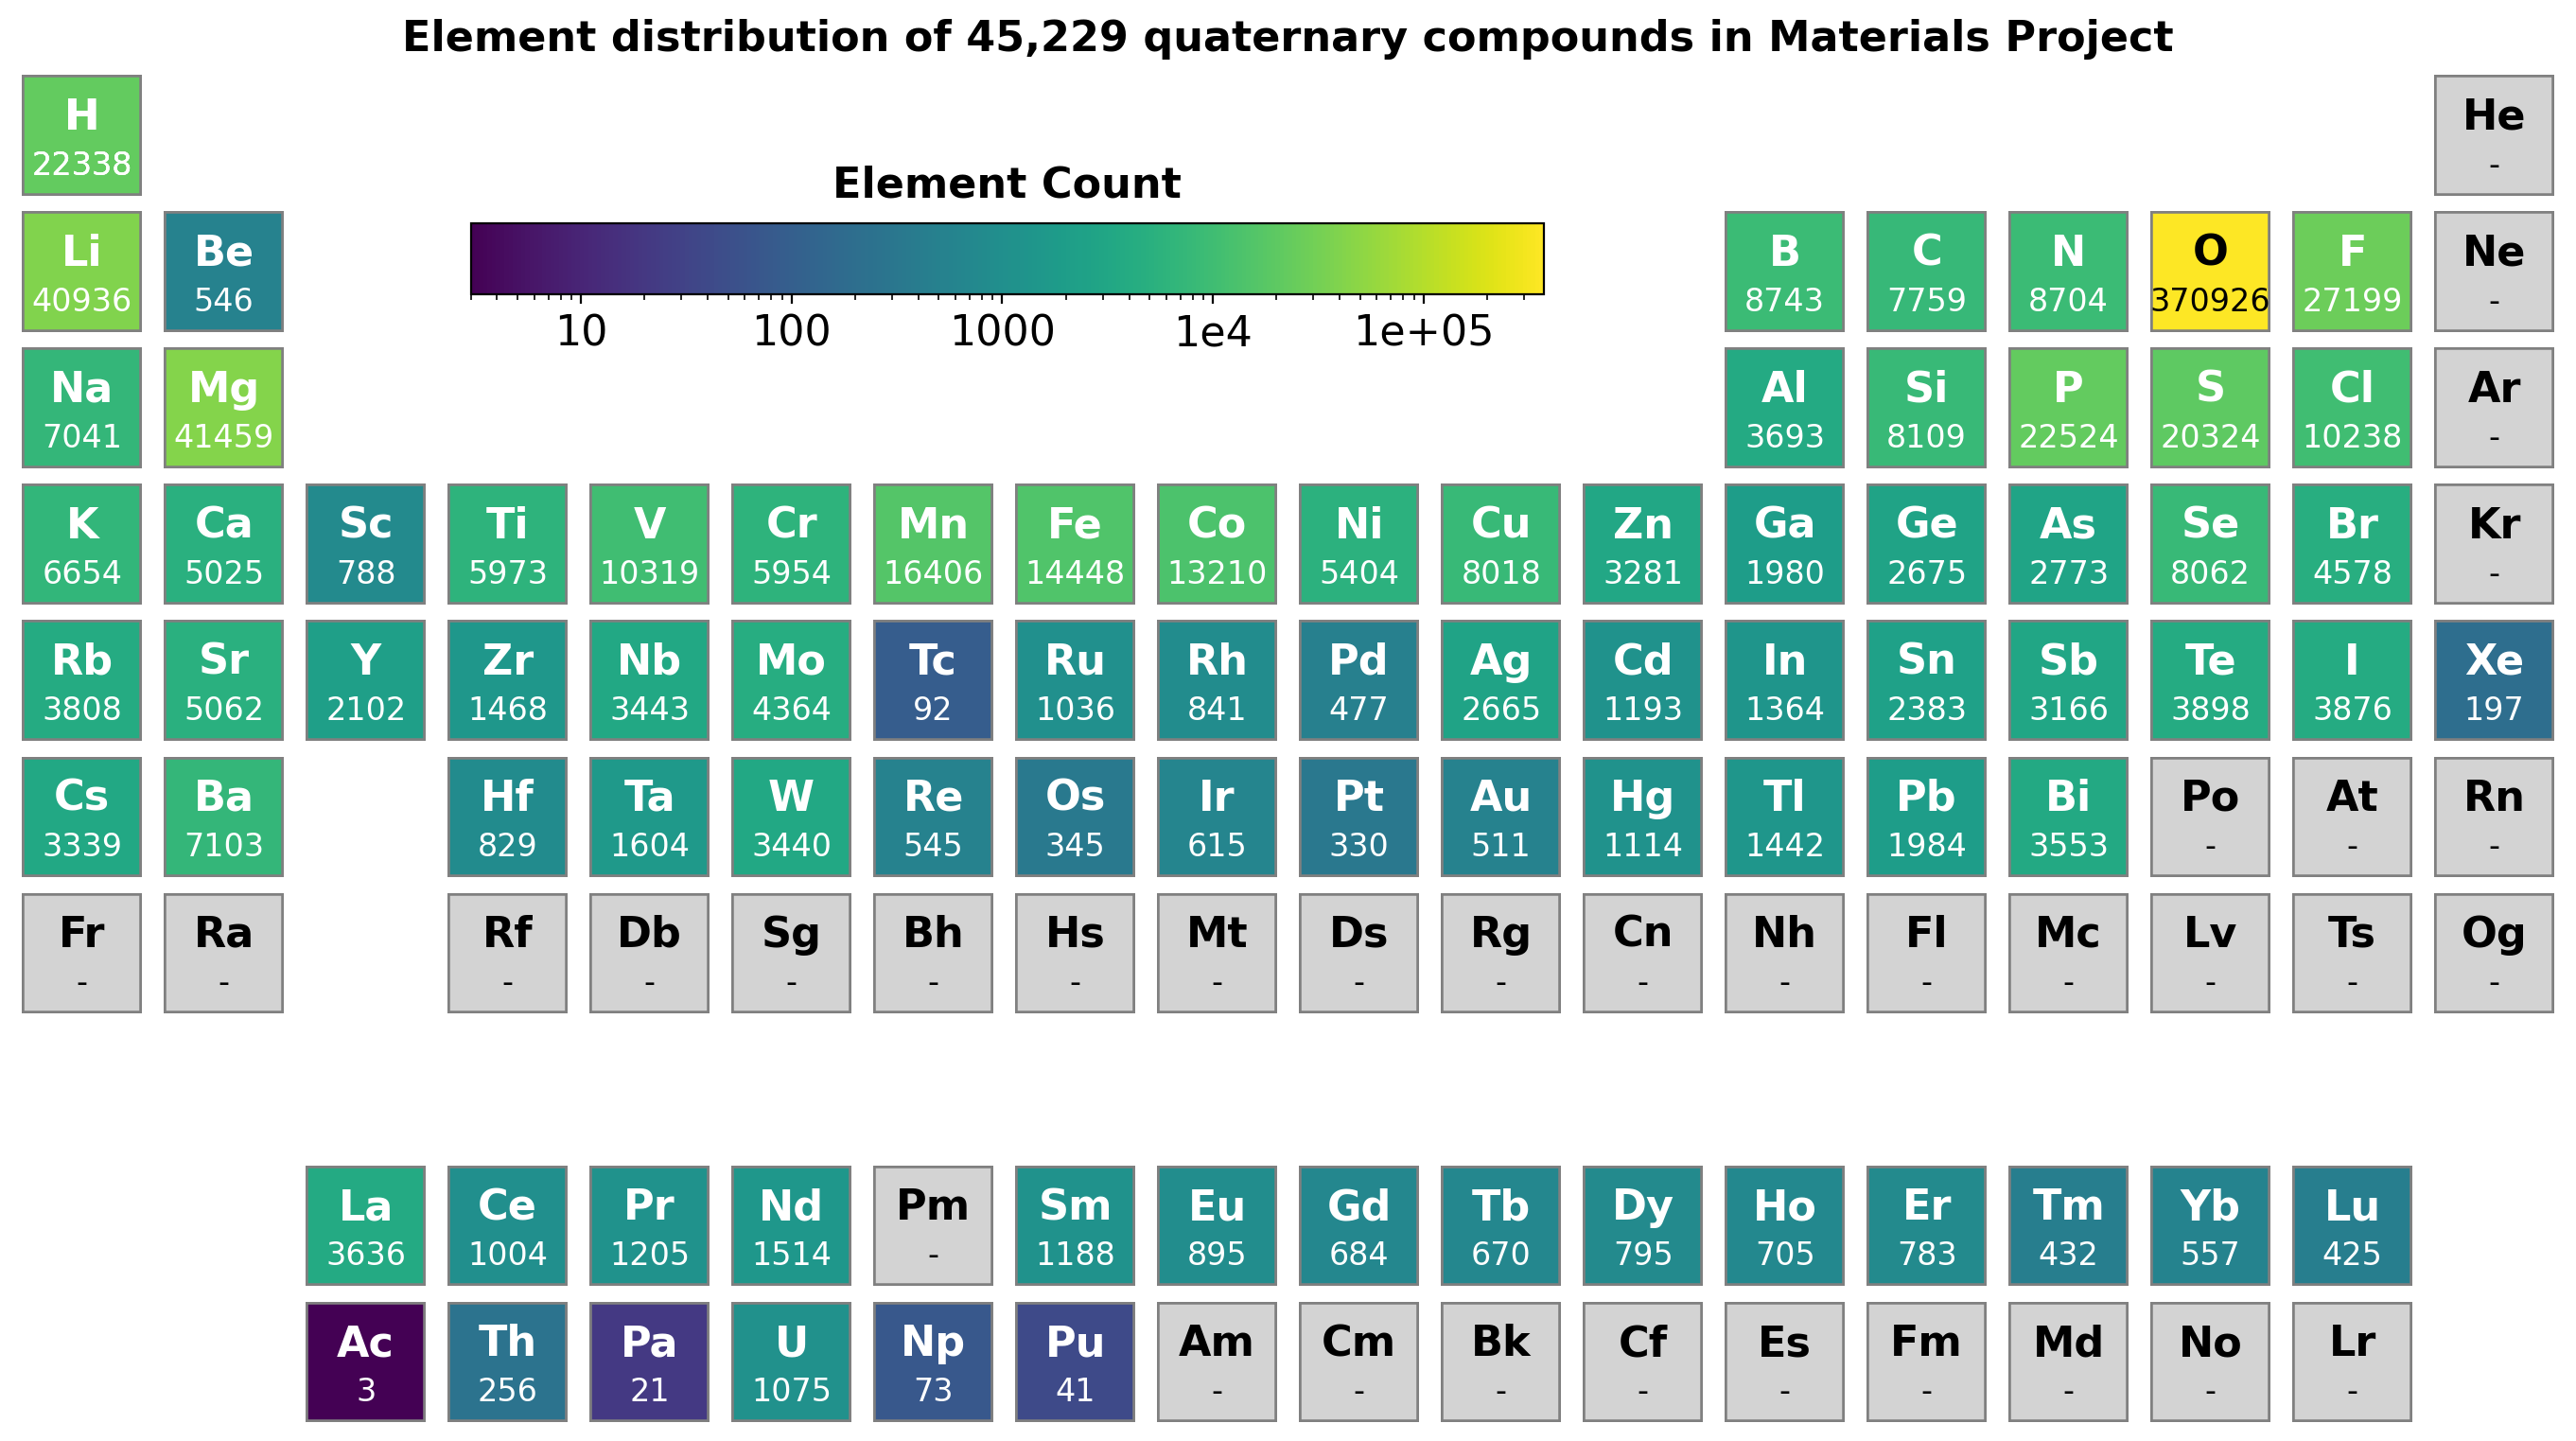

In [ ]:
for arity_label, elem_counts in elem_counts_by_arity.items():
    fig = ptable_heatmap(
        elem_counts, log=True, value_kwargs={"fontsize": 12}, return_type="figure"
    )
    n_compounds = compound_counts_by_arity[arity_label]
    fig.suptitle(
        f"Element distribution of {n_compounds:,} {arity_label} compounds in "
        "Materials Project",
        fontsize=16,
        fontweight="bold",
    )

In [ ]:
arity_figs = {}
for arity_label, elem_counts in elem_counts_by_arity.items():
    fig = ptable_heatmap_plotly(
        elem_counts,
        hover_props=["atomic_number", "type"],
        heat_mode="percent",
    )
    n_compounds = compound_counts_by_arity[arity_label]

    title = (
        f"<b>Element distribution of {n_compounds:,} <i>{arity_label}</i> compounds<br>"
        "in Materials Project</b>"
    )
    fig.layout.title = dict(text=title, x=0.45, y=0.93)
    arity_figs[arity_label] = fig
    # fig.show()  # uncomment to show plotly figures

In [ ]:
app = dash.Dash(prevent_initial_callbacks=True)

graph = dash.dcc.Graph(figure=fig, id="ptable-heatmap", responsive=True)
dropdown = dash.dcc.Dropdown(
    id="arity-dropdown",
    options=[
        dict(label=arity_label, value=arity_label)
        for arity_label in elem_counts_by_arity
    ],
    style=dict(width="15em", position="absolute", top="15%", left="30%"),
    value="unary",
    placeholder="Select arity",
)
main_layout = dash.html.Div([graph, dropdown], style=dict(fontFamily="sans-serif"))
app.layout = main_layout


@app.callback(Output(graph.id, "figure"), Input(dropdown.id, "value"))
def update_figure(dropdown_value: str) -> go.Figure:
    """Update figure based on dropdown value."""
    return arity_figs[dropdown_value]


app.run(debug=True, mode="inline")